# MARIO multiple datasets matching and integration pipeline

This tutorial will guide you through matching and integrating multiple datasets. For more detailed step-by-step guidance please refer the previous tutorial.

This script will include matching and integration of 4 cross species datasets. The data is same as we presented in the [paper](https://www.google.com/webhp?hl=en&ictx=2&sa=X&ved=0ahUKEwjdv9mYldfyAhUrJTQIHS4jBcQQPQgJ). First we load up MARIO in python:


In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from mario.match import Mario # main object
from mario.match_utils import eval_matching_accuracy # for evaluating matching accuracy
from mario.match import pipelined_mario # for running the overall pipeline

## 1. Read in data

We read in the four datasets, both protein features, with row as cells and column with features: overlapping or non-overlapping protein types (remember to make sure overlapping proteins have the same name accross datasets, although in this case all four datasets have largely overlapping antibody panels, since they are all performed at the Nolan lab at Stanford). 

The four datasets here includes CYTOF data measuring human and non-human primates whole blood cells, challenged with H1N1 or Interferon gamma. Each Original dataset contains **~ 100-120k** cells. For simplicity of this tutorial, we only use a subset of these cells (each dataset to **20k** cells). Here we use the first dataset (Human challenged with H1N1) as the core dataset that matched towards the other 3 datasets.

In [2]:
df1 = pd.read_csv("/home/bkzhu/SNE-multi/figure_rcode/figure_related_code_submit/data/Cytof-Xspecies-IFNG/wcct4d_term_srcluster120k.csv")
df2 = pd.read_csv("/home/bkzhu/SNE-multi/figure_rcode/figure_related_code_submit/data/Cytof-Xspecies-IFNG/zac_ifgn_term_srcluster120k.csv")
df3 = pd.read_csv("/home/bkzhu/SNE-multi/figure_rcode/figure_related_code_submit/data/Cytof-Xspecies-IFNG/zac_Rheus_ifgn_term_srcluster120k.csv")
df4 = pd.read_csv("/home/bkzhu/SNE-multi/figure_rcode/figure_related_code_submit/data/Cytof-Xspecies-IFNG/zac_Cyno_ifgn_term_srcluster120k.csv")

### for tutorial downsample the cells, each dataset 20k cells
np.random.seed(42)
df1 = df1.iloc[np.random.choice(df1.shape[0], 20000, replace=False), :]
df2 = df2.iloc[np.random.choice(df2.shape[0], 20000, replace=False), :]
df3 = df3.iloc[np.random.choice(df3.shape[0], 20000, replace=False), :]
df4 = df4.iloc[np.random.choice(df4.shape[0], 20000, replace=False), :]

# cell type annotations, used for downstream analysis etc
df1_labels = df1['cluster.sr'].to_numpy()
df2_labels = df2['cluster.sr'].to_numpy()
df3_labels = df3['cluster.sr'].to_numpy()
df4_labels = df4['cluster.sr'].to_numpy()
# remove non-numerical columns
df1 = df1.drop(['Unnamed: 0','X','index', 'cluster.orig', 'cluster.sr'], 1)
df2 = df2.drop(['Unnamed: 0','X','index', 'cluster.orig', 'cluster.sr'], 1)
df3 = df3.drop(['Unnamed: 0','X','index', 'cluster.orig', 'cluster.sr'], 1)
df4 = df4.drop(['Unnamed: 0','X','index', 'cluster.orig', 'cluster.sr'], 1)

## 2. Match and integrate with MARIO

Here we will just match and integrate the 4 datasets in the pipeline fashion. Note for optimal performance, you should do intial screen of the hyper paprameters, as show cased in the previous [tutorials]().

Here we just used a set of parameters generally should perform well. This chunk of code should take ~40 mins and <2 GB memory usage. The matching and integration of the full size dataset presented in the paper took couple hours.

In [3]:
import timeit
start = timeit.default_timer() # just recording the time
final_matching_lst, embedding_lst = pipelined_mario(
    data_lst=[df1,df2,df3,df4], normalization=True, n_batches=4,
    n_matched_per_cell=1, sparsity_ovlp=500, sparsity_all=500,
    n_components_ovlp=15, n_components_all=15,
    n_cancor=5, n_wts=4,
    n_clusters=10, n_components_filter=10, bad_prop=0.2, max_iter_filter=20,
    knn=False, embed_dim=10, max_iter_embed=500, save_path='../data', verbose=False
)
end = timeit.default_timer()

Matching data_lst[0] with data_lst[1]
Now at batch 0
Matching using overlapping features...
Matching using all features...
Finding the best interpolated matching...
Filtering bad matched pairs...
Now at batch 1
Matching using overlapping features...
Matching using all features...
Finding the best interpolated matching...
Filtering bad matched pairs...
Now at batch 2
Matching using overlapping features...
Matching using all features...
Finding the best interpolated matching...
Filtering bad matched pairs...
Now at batch 3
Matching using overlapping features...
Matching using all features...
Finding the best interpolated matching...
Filtering bad matched pairs...
Stitching batch-wise matchings together...
Matching data_lst[0] with data_lst[2]
Now at batch 0
Matching using overlapping features...
Matching using all features...
Finding the best interpolated matching...
Filtering bad matched pairs...
Now at batch 1
Matching using overlapping features...
Matching using all features...
Findin

## 4. Downstream Analysis

After the MARIO matching and integration pipeline, we can perform various downstream analysis. Here we will just do some simple showcase of t-sne visualization. These results are also saved out and are compatible for furthur analysis with popular packages eg ```scanpy```

First we can make the t-sne plots:

In [9]:
import seaborn as sns
from sklearn.manifold import TSNE
# do t-sne plotting
tsne = TSNE(n_components=2, verbose=0, perplexity=30, n_iter=1000)
# only use 10 components
tsne_results = tsne.fit_transform(np.vstack([embedding_lst[0][:,0:10], 
                                             embedding_lst[1][:,0:10],
                                             embedding_lst[2][:,0:10],
                                             embedding_lst[3][:,0:10]]))
embedding_gcca = pd.DataFrame(tsne_results, columns = ['tsne1', 'tsne2'])


And we can then visualize the integrated four datasets:

<AxesSubplot:xlabel='tsne1', ylabel='tsne2'>

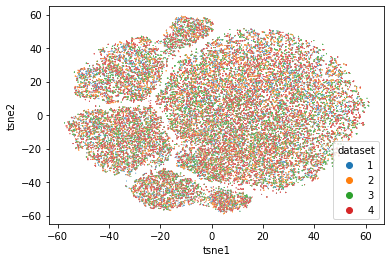

In [20]:
# input labels dataset of origin
embedding_gcca['dataset'] = np.repeat(["1","2","3","4"],
                                      [embedding_lst[0].shape[0],
                                       embedding_lst[0].shape[0],
                                      embedding_lst[0].shape[0],
                                      embedding_lst[0].shape[0]], axis=0)
#fig=plt.figure(figsize=(9,5), dpi= 100, facecolor='w', edgecolor='k')
sns.scatterplot(data=embedding_gcca, x='tsne1', y='tsne2', hue='dataset', s=1)


Also we can look at the cell type annotations from each datasets:

In [12]:
# we can also color by cell types

## reformat the MARIO matching results
df1_rowidx=list(range(len(final_matching_lst[0])))
filtered_out1=[i for i,x in enumerate(final_matching_lst[1]) if not x] # 1->2 failed
filtered_out2=[i for i,x in enumerate(final_matching_lst[2]) if not x] # 1->3 failed
filtered_out3=[i for i,x in enumerate(final_matching_lst[3]) if not x] # 1->4 failed
filtered_all = np.union1d(np.union1d(filtered_out1, filtered_out2),filtered_out3) # only take 1 -> 2,3,4 cells

match_final_df1 =[e for e in df1_rowidx if not e in filtered_all]
match_final_df2 = [j for e,j in enumerate([x for x in final_matching_lst[1]]) if not e in filtered_all]
match_final_df3 = [j for e,j in enumerate([x for x in final_matching_lst[2]]) if not e in filtered_all]
match_final_df4 = [j for e,j in enumerate([x for x in final_matching_lst[3]]) if not e in filtered_all]

# find the original labels
embedding_gcca['annotation'] = np.hstack([df1_labels[match_final_df1], df2_labels[match_final_df2].flatten(),
                                         df3_labels[match_final_df3].flatten(), df4_labels[match_final_df4].flatten()])

<AxesSubplot:xlabel='tsne1', ylabel='tsne2'>

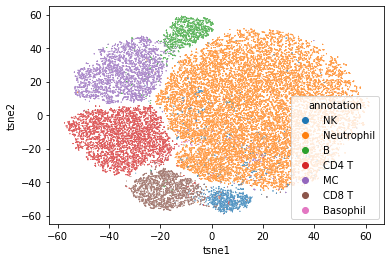

In [18]:
sns.scatterplot(data=embedding_gcca.iloc[:,:], x='tsne1', y='tsne2', hue='annotation', s=1)

Our compare by individual datasets

<AxesSubplot:xlabel='tsne1', ylabel='tsne2'>

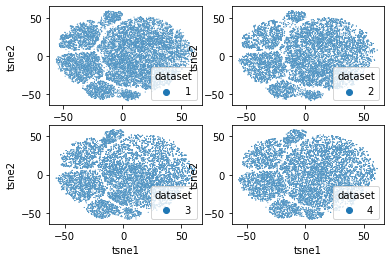

In [23]:
fig, axs = plt.subplots(ncols=2, nrows =2)
sns.scatterplot(data=embedding_gcca.iloc[0:15209*1,:],
                x='tsne1', y='tsne2', hue='dataset', s=1, ax=axs[0,0]) # dataset1
sns.scatterplot(data=embedding_gcca.iloc[15210:15209*2,:],
                x='tsne1', y='tsne2', hue='dataset', s=1, ax=axs[0,1]) # dataset2
sns.scatterplot(data=embedding_gcca.iloc[15209*2+1:15209*3,:],
                x='tsne1', y='tsne2', hue='dataset', s=1, ax=axs[1,0]) # dataset3
sns.scatterplot(data=embedding_gcca.iloc[15209*3+1:15209*4,:],
                x='tsne1', y='tsne2', hue='dataset', s=1, ax=axs[1,1]) # dataset4